# Artificial Intelligence of Things - Demonstration

This document describes methods and mechanisms for the execution of
Artificial Neural Networks in devices with low computational power.

## Dataset
### Load the Yaleface dataset

In [1]:
import src.dataset.yalefaces as yalefaces
import numpy as np

np.random.seed(99)

In [2]:
import numpy as np
X, y = yalefaces.load("data/yalefaces", flatten=True)
X = X.astype("float32") / 255.0

print(f"Loaded {int(X.shape[0]/len(np.unique(y)))} faces from {len(np.unique(y))} individuals,"
f" a total of {X.shape[0]} images of size {yalefaces.SHAPE} ({X[0].shape[0]} pixels).")

Loaded 11 faces from 15 individuals, a total of 165 images of size (243, 320) (77760 pixels).


### Compress faces with Principal Ccomponent Analysis (PCA)

In [3]:
from sklearn.decomposition import PCA

num_faces, num_pixels = X.shape
num_principal_components = int(num_faces)

pca = PCA(n_components=num_principal_components)
pca.fit(X)

print(f"PCA generated {num_principal_components} eigenfaces of size {yalefaces.SHAPE}.")

PCA generated 165 eigenfaces of size (243, 320).


In [4]:
X_compressed = pca.transform(X)

## Train MLP
### Use GPU if NVIDIA CUDA is available

In [5]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


### Create train and test datasets

In [6]:
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split

X_train_compressed, X_test_compressed, y_train_compressed, y_test_compressed = train_test_split(X_compressed, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

X_train = torch.Tensor(X_train_compressed)
y_train = torch.LongTensor(y_train_compressed)
train_dataset = TensorDataset(X_train, y_train)

X_test = torch.Tensor(X_test_compressed)
y_test = torch.LongTensor(y_test_compressed)
test_dataset = TensorDataset(X_test, y_test)

### Build a Multilayer Perceptron

In [7]:
from src.models.mlp import MLP
import torch.nn as nn

model = MLP(in_dim=165, out_dim=15, hidden_sizes=[96, 48], activation=nn.ReLU)
model = model.to(device)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0001)

In [9]:
import torch.nn.functional as F

def train(model, device, train_loader, optimizer, loss_fn=F.cross_entropy):
    model.train()

    epoch_loss = 0
    n_samples = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        # prepare
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        # compute
        output = model(data)
        loss = loss_fn(output, target)

        # record
        epoch_loss += loss.item()
        n_samples += output.size(0)

        # adjust
        loss.backward()
        optimizer.step()

    return epoch_loss, n_samples

In [10]:
def test(model, device, test_loader):
    with torch.no_grad():
        model.train(False)
        num_correct = 0
        num_samples = 0

        for batch_idx, (x, y) in enumerate(test_loader):
            x = x.to(device)
            y = y.to(device)

            scores = model.forward(x)
            _, y_out = scores.max(1)
            
            num_correct += (y_out == y).sum()
            num_samples += y_out.size(0)
        
        acc = float(num_correct) / float(num_samples)
    return acc

In [11]:
import numpy as np
from torch.utils.data import DataLoader

train_accs= []
train_losses = []

for epoch in range(200):
    # train
    train_data = DataLoader(train_dataset, batch_size=64, shuffle=True)
    err, n_train_samples = train(model, device, train_data, optimizer)
    loss = float(err)/float(n_train_samples)
    train_losses.append(loss)
    
    # evaluate
    acc = test(model, device, train_data)
    train_accs.append(acc)


### Training loss

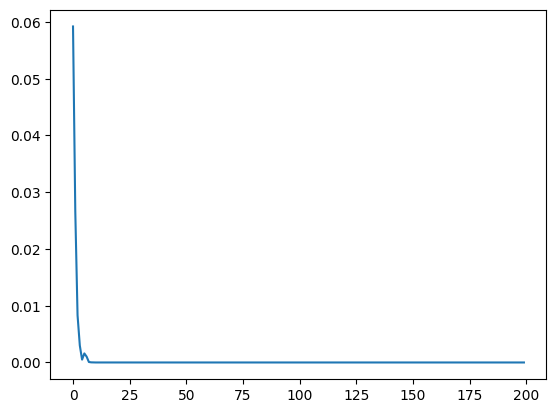

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses)

### Training accuracy

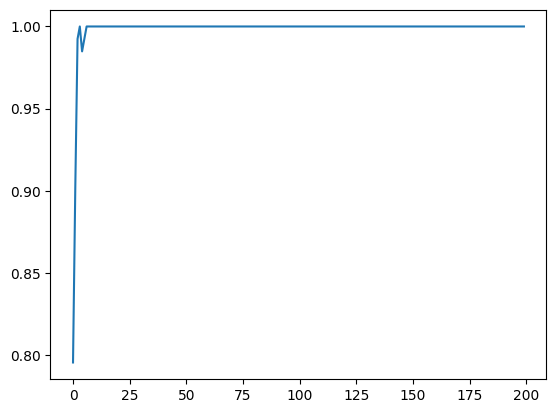

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_accs)

### Test accuracy

In [14]:
test_data = DataLoader(test_dataset, batch_size=len(test_dataset))
acc = test(model, device, test_data)
print(f"Test accuracy: {acc * 100:.2f}")


Test accuracy: 81.82


## Quantize model
### Prepare model for quantization

Recall that our model has the following shape:

```python
model = nn.Sequential(
    nn.Linear(165, 96, bias=True),
    nn.ReLU(),
    nn.Linear(96, 48, bias=True),
    nn.ReLU(),
    nn.Linear(48, 15, bias=False)
)
```

In [15]:
import copy
import torch
from torch import nn

# copy our original model
qmodel_float = copy.deepcopy(model.net)
qmodel_float.eval()

# prepare layers
torch.quantization.fuse_modules(qmodel_float, ['0', '1'], inplace=True)
torch.quantization.fuse_modules(qmodel_float, ['2', '3'], inplace=True)

# add quantization layers for input and output
qmodel_float = nn.Sequential(
    torch.quantization.QuantStub(),
    *qmodel_float,
    torch.quantization.DeQuantStub()
)

### Configure quantization

In [16]:
qmodel_float.qconfig = torch.quantization.default_qconfig
qmodel_float=qmodel_float.to('cpu')

torch.quantization.prepare(qmodel_float, inplace=True)

Sequential(
  (0): QuantStub(
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (1): LinearReLU(
    (0): Linear(in_features=165, out_features=96, bias=False)
    (1): ReLU()
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (2): Identity()
  (3): LinearReLU(
    (0): Linear(in_features=96, out_features=48, bias=False)
    (1): ReLU()
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (4): Identity()
  (5): Linear(
    in_features=48, out_features=15, bias=False
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (6): DeQuantStub()
)

### Quantize network

In [17]:
# learn quantization parameters
with torch.inference_mode():
    for batch_idx, (x, y) in enumerate(test_data):
        x,y = x.to('cpu'), y.to('cpu')
        qmodel_float(x)

# actually quantize weights
qmodel = torch.quantization.convert(qmodel_float, inplace=False)

### Weights size before and after quantization

In [18]:
print("Weight size before quantization:", qmodel_float[1][0].weight.element_size(), "byte(s)")
print("Weight size after quantization:", qmodel[1].weight().element_size(), "byte(s)")

Weight size before quantization: 4 byte(s)
Weight size after quantization: 1 byte(s)


### Accuracy of the quantized model

In [19]:
test_data = DataLoader(test_dataset, batch_size=len(test_dataset))
acc = test(qmodel, 'cpu', test_data)
print(f"Test accuracy: {acc * 100:.2f}")

Test accuracy: 78.79


### Model sizes in KB

In [20]:
import os
import torch

def print_model_size(mdl, name):
    torch.save(mdl.state_dict(), "tmp.pt")
    print(f"{name}: %.3f KB" %(os.path.getsize("tmp.pt")/1e3))
    os.remove('tmp.pt')

print_model_size(model, "Original ")
print_model_size(qmodel, "Quantized")

Original : 86.051 KB
Quantized: 24.900 KB


## Export quantized model

### Floating- to fixed-point conversion algorithm

In [21]:
# scale=0.390065997838974, zero_point=59
s = 0.390065997838974
z = 59

# to be quantized: x
x = 73

qx = round((x/s)+z)
dqx = (qx-z)*s

print(f"Original: {x}")
print(f"Quantized: {qx}")
print(f"Dequantized: {dqx}")

Original: 73
Quantized: 246
Dequantized: 72.94234159588814


### Read weights and quantization parameters

In [22]:
model_params=qmodel_float.state_dict()

In [23]:
model_params

OrderedDict([('0.activation_post_process.eps', tensor([1.1921e-07])),
             ('0.activation_post_process.min_val', tensor(-64.7021)),
             ('0.activation_post_process.max_val', tensor(89.3256)),
             ('1.0.weight',
              tensor([[-8.5280e-02,  2.3521e-03, -8.3315e-02,  ...,  5.5971e-08,
                        1.2918e-08, -1.7495e-07],
                      [-1.0333e-01,  2.8432e-02, -3.8504e-02,  ..., -7.5666e-08,
                        6.2811e-08,  4.6508e-07],
                      [-3.5493e-02, -4.4640e-02,  1.0966e-02,  ..., -1.2909e-07,
                       -2.6232e-07, -3.7944e-07],
                      ...,
                      [ 1.1109e-02, -4.1541e-02,  7.4070e-03,  ...,  1.2304e-07,
                        7.9837e-08,  6.3136e-08],
                      [ 6.4905e-02,  2.0859e-02, -1.6522e-01,  ...,  4.4794e-08,
                        7.6903e-08, -7.7207e-08],
                      [ 2.4909e-02, -2.6287e-02, -2.2010e-02,  ...,  6.2623e-08,


In [24]:
def get_layer_weights(model_state_dict, layer_idx):
    if f'{layer_idx}.0.weight' in model_state_dict.keys():
        weights = model_state_dict[f'{layer_idx}.0.weight'].numpy()
    elif f'{layer_idx}.weight' in model_state_dict.keys():
        weights = model_state_dict[f'{layer_idx}.weight'].numpy()
    else:
        raise KeyError(f'{layer_idx}.0.weight or {layer_idx}.weight')
    return weights

def get_layer_min(model_state_dict, layer_idx):
    return model_state_dict[f'{layer_idx}.activation_post_process.min_val'].numpy()

def get_layer_max(model_state_dict, layer_idx):
    return model_state_dict[f'{layer_idx}.activation_post_process.max_val'].numpy()

def get_scale(model_state_dict, layer_idx):
    return model_state_dict[f'{layer_idx}.activation_post_process.max_val'].numpy()

### Export quantized weights

In [25]:
import numpy as np

layer_indexes = [1, 3, 5]
with open('mlp_params.c', 'w') as source, open('mlp_params.h', 'w') as header:
    header.write('#ifndef MLP_PARAMS\n#define MLP_PARAMS\n\n')
    header.write('#include <stdint.h>\n\n\n')
    
    source.write('#include "mlp_params.h"\n\n')
    
    for layer in layer_indexes:
        # get raw weights and quantization parameters
        weights = get_layer_weights(model_params, layer).flatten()
        xmin = get_layer_min(model_params, layer)
        xmax = get_layer_max(model_params, layer)
        
        header.write(f"extern const int8_t layer_{layer}_weights[{len(weights)}];\n")
        
        # compute quantization parameters
        num_bits = 8
        qmin = -127
        qmax = 128
        eps = 1.1921e-07
        # scale = (2 * np.maximum(np.abs(amin), amax)) / (2**num_bits)
        # zero = amin

        # FROM: https://pytorch.org/docs/stable/generated/torch.quantization.observer.MinMaxObserver.html#torch.quantization.observer.MinMaxObserver
        scale = (xmax - xmin)/(qmax - qmin)
        zero = qmin - np.around(xmin/scale)

        # FROM: https://pytorch.org/docs/stable/_modules/torch/ao/quantization/observer.html#MinMaxObserver.calculate_qparams
        # max_val_pos = np.amax(np.array([-xmin, xmax]))
        # scale = max_val_pos / (float(qmax - qmin) / 2)
        # scale = np.amax(np.array([scale, eps]))
        # zero = np.array(0.0)

        print(f"scale={scale}, min={xmin}, max={xmax}, zero={zero}, W[0]={weights[0]}")

        # FIXME: convertion is not working properly yet...
        
        weights_fp = (np.around((weights / scale) + zero)).astype(int)

        # weights_fp = (w - zero) * scale # this should be the reverse operation actually...

        source.write(f"const int8_t layer_{layer}_weights[{len(weights)}] = {{")
        for i in range(len(weights)-1):
            source.write(f"{weights_fp[i]}, ")
        source.write(f"{weights_fp[len(weights)-1]}}};\n\n")

    header.write('\n#endif // end of MLP_PARAMS\n')

        

scale=0.08484856100643383, min=0.0, max=21.636383056640625, zero=-127.0, W[0]=-0.08528020232915878
scale=0.08294599944469976, min=0.0, max=21.151229858398438, zero=-127.0, W[0]=-0.012770934030413628
scale=0.13837990854300705, min=-18.89534568786621, max=16.391530990600586, zero=10.0, W[0]=0.03193146362900734


### Experimenting with layer0:

In [26]:
import numpy as np

layer_indexes = [1]
with open('mlp_params.c', 'w') as source, open('mlp_params.h', 'w') as header:
    header.write('#ifndef MLP_PARAMS\n#define MLP_PARAMS\n\n')
    header.write('#include <stdint.h>\n\n\n')
    
    source.write('#include "mlp_params.h"\n\n')
    
    for layer in layer_indexes:
        # get raw weights and quantization parameters
        weights = get_layer_weights(model_params, layer).flatten()
        xmin = get_layer_min(model_params, layer)
        xmax = get_layer_max(model_params, layer)
        
        header.write(f"extern const int8_t layer_{layer}_weights[{len(weights)}];\n")
        
        # compute quantization parameters
        num_bits = 8
        qmin = -127
        qmax = 128
        eps = 1.1921e-07
        
        

        # FROM: https://pytorch.org/docs/stable/generated/torch.quantization.observer.MinMaxObserver.html#torch.quantization.observer.MinMaxObserver
        scale = (xmax - xmin)/(qmax - qmin)
        
        scale = 2 * np.maximum(np.abs(xmin), xmax) / (qmax - qmin)
        zero = 0.0
        # zero = qmin - np.around(xmin/scale)

        # FROM: https://pytorch.org/docs/stable/_modules/torch/ao/quantization/observer.html#MinMaxObserver.calculate_qparams
        # max_val_pos = np.amax(np.array([-xmin, xmax]))
        # scale = max_val_pos / (float(qmax - qmin) / 2)
        # scale = np.amax(np.array([scale, eps]))
        # zero = np.array(0.0)

        # FIXME: convertion is not working properly yet...
        weights_fp = (np.around((weights / scale) + zero)).astype(int)
        # weights_fp = (weights - zero) * scale
        
        print(f"scale={scale}, min={xmin}, max={xmax}, zero={zero}")
        for i in range(4):
            print(f"\tW[{i}]={weights[i]}, Wq[{i}]={weights_fp[i]}")

        # weights_fp = (weights - zero) * scale # this should be the reverse operation actually...

        source.write(f"const int8_t layer_{layer}_weights[{len(weights)}] = {{")
        for i in range(len(weights)-1):
            source.write(f"{weights_fp[i]}, ")
        source.write(f"{weights_fp[len(weights)-1]}}};\n\n")

    header.write('\n#endif // end of MLP_PARAMS\n')

scale=0.16969712201286766, min=0.0, max=21.636383056640625, zero=0.0
	W[0]=-0.08528020232915878, Wq[0]=-1
	W[1]=0.0023521280381828547, Wq[1]=0
	W[2]=-0.08331505954265594, Wq[2]=0
	W[3]=-0.10155779868364334, Wq[3]=-1


In [27]:
layer=1
weights = get_layer_weights(model_params, layer).flatten()
xmin = get_layer_min(model_params, layer)
xmax = get_layer_max(model_params, layer)

print(np.amax(weights))
print(np.amin(weights))

0.22388823
-0.26871186


In [28]:
qmodel_params = qmodel.state_dict()
print(qmodel_params)

OrderedDict([('0.scale', tensor([1.2128])), ('0.zero_point', tensor([53])), ('1.scale', tensor(0.1704)), ('1.zero_point', tensor(0)), ('1._packed_params.dtype', torch.qint8), ('1._packed_params._packed_params', (tensor([[-0.0843,  0.0021, -0.0843,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1033,  0.0274, -0.0379,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0358, -0.0443,  0.0105,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0105, -0.0422,  0.0084,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0653,  0.0211, -0.1644,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0253, -0.0253, -0.0211,  ...,  0.0000,  0.0000,  0.0000]],
       size=(96, 165), dtype=torch.qint8,
       quantization_scheme=torch.per_tensor_affine, scale=0.0021075441036373377,
       zero_point=0), None)), ('3.scale', tensor(0.1665)), ('3.zero_point', tensor(0)), ('3._packed_params.dtype', torch.qint8), ('3._packed_params._packed_params', (tensor([[-0.0118, -0.0216,  0.1435,  ..., -0.1356,  0.0157,  0.06

In [29]:
layer_idx = 1
t = qmodel_params[f'{layer_idx}._packed_params._packed_params']
print(t[0][0].q_scale())

0.0021075441036373377


In [30]:
import numpy as np

layer_indexes = [1]
with open('mlp_params.c', 'w') as source, open('mlp_params.h', 'w') as header:
    header.write('#ifndef MLP_PARAMS\n#define MLP_PARAMS\n\n')
    header.write('#include <stdint.h>\n\n\n')
    
    source.write('#include "mlp_params.h"\n\n')
    
    for layer in layer_indexes:
        # get raw weights and quantization parameters
        weights = get_layer_weights(model_params, layer).flatten()
        xmin = get_layer_min(model_params, layer)
        xmax = get_layer_max(model_params, layer)
        scale = get_scale(qmodel_params, layer) # FIXME implement get_scale using the cell code above
        
        header.write(f"extern const int8_t layer_{layer}_weights[{len(weights)}];\n")
        
        # compute quantization parameters
        num_bits = 8
        qmin = -127
        qmax = 128
        eps = 1.1921e-07
        
        

        # FROM: https://pytorch.org/docs/stable/generated/torch.quantization.observer.MinMaxObserver.html#torch.quantization.observer.MinMaxObserver
        scale = (xmax - xmin)/(qmax - qmin)
        
        scale = 2 * np.maximum(np.abs(xmin), xmax) / (qmax - qmin)
        zero = 0.0
        # zero = qmin - np.around(xmin/scale)

        # FROM: https://pytorch.org/docs/stable/_modules/torch/ao/quantization/observer.html#MinMaxObserver.calculate_qparams
        # max_val_pos = np.amax(np.array([-xmin, xmax]))
        # scale = max_val_pos / (float(qmax - qmin) / 2)
        # scale = np.amax(np.array([scale, eps]))
        # zero = np.array(0.0)

        # FIXME: convertion is not working properly yet...
        weights_fp = (np.around((weights / scale) + zero)).astype(int)
        # weights_fp = (weights - zero) * scale
        
        print(f"scale={scale}, min={xmin}, max={xmax}, zero={zero}")
        for i in range(4):
            print(f"\tW[{i}]={weights[i]}, Wq[{i}]={weights_fp[i]}")

        # weights_fp = (weights - zero) * scale # this should be the reverse operation actually...

        source.write(f"const int8_t layer_{layer}_weights[{len(weights)}] = {{")
        for i in range(len(weights)-1):
            source.write(f"{weights_fp[i]}, ")
        source.write(f"{weights_fp[len(weights)-1]}}};\n\n")

    header.write('\n#endif // end of MLP_PARAMS\n')

KeyError: '1.activation_post_process.max_val'